<a href="https://colab.research.google.com/github/neethu-1983/Boosting-Techniques/blob/master/BOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics.scorer import make_scorer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


First up we'll download the last few years of load data from the Australian Energy Market Operator and narrow it down just the Trading Interval (datetime) and Metered Generation data.

I've chosen to drop blank records because they break Random Forest, but there are some cases where you would want to interpolate them.

In [0]:
%%time
df = pd.read_csv('http://data.wa.aemo.com.au/datafiles/load-summary/load-summary-2010.csv', parse_dates=['Trading Date','Trading Interval'])
for i in range(2011, 2020):
  df=df.append(pd.read_csv('http://data.wa.aemo.com.au/datafiles/load-summary/load-summary-'+str(i)+'.csv', 
                           parse_dates=['Trading Date','Trading Interval']))
df=df[['Trading Interval', 'Metered Generation (Total; MWh)']].dropna()

CPU times: user 524 ms, sys: 123 ms, total: 647 ms
Wall time: 1min 51s


A quick check of the data shows that it's in half hour time slots and that generation is measured in megawatt hours, you'll need to double these values if you're used to working in average megawatts.

In [0]:
df.insert(len(df.columns), 'hour', df['Trading Interval'].dt.hour + df['Trading Interval'].dt.minute/60)
df.insert(len(df.columns), 'weekday', df['Trading Interval'].dt.weekday)
df.insert(len(df.columns), 'month', df['Trading Interval'].dt.month)
df.insert(len(df.columns), 'year', df['Trading Interval'].dt.year)


In [0]:
%%time
max_temp = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1CHwEwl6A4uqRq_2Q6rtcoICqEMehYR1X&export=download')
min_temp = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1HJV8HtzRlTG_Tn12gUEPemqNt-4E-QWo&export=download')
temp = max_temp.merge(min_temp, left_on=['Year','Month','Day'], right_on=['Year','Month','Day']).dropna()
temp = temp[['Year','Month','Day','Maximum temperature (Degree C)', 'Minimum temperature (Degree C)']]
df.insert(len(df.columns), 'day', df['Trading Interval'].dt.day)
df = df.merge(temp, left_on=['year','month','day'], right_on=['Year','Month','Day']).drop(['day', 'Year', 'Month', 'Day'], axis=1)


CPU times: user 133 ms, sys: 11.1 ms, total: 144 ms
Wall time: 3.06 s


In [0]:
%%time
temp['max_lag1'] = temp['Maximum temperature (Degree C)'].shift(periods=1)
temp['min_lag1'] = temp['Minimum temperature (Degree C)'].shift(periods=1)
temp['max_lag2'] = temp['Maximum temperature (Degree C)'].shift(periods=2)
temp['min_lag2'] = temp['Minimum temperature (Degree C)'].shift(periods=2)
df = df.drop(['Maximum temperature (Degree C)', 'Minimum temperature (Degree C)'], axis=1)
df.insert(len(df.columns), 'day', df['Trading Interval'].dt.day)
df = df.merge(temp, left_on=['year','month','day'], right_on=['Year','Month','Day']).drop(['day', 'Year', 'Month', 'Day'], axis=1)

CPU times: user 62.4 ms, sys: 5.82 ms, total: 68.2 ms
Wall time: 68.2 ms


In [0]:
df

,Trading Interval,Metered Generation (Total; MWh),hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2
0,2010-01-01 08:00:00,756.341197,8.0,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
1,2010-01-01 08:30:00,780.548255,8.5,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
2,2010-01-01 09:00:00,802.185847,9.0,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
3,2010-01-01 09:30:00,823.865739,9.5,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
4,2010-01-01 10:00:00,834.215943,10.0,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
...,...,...,...,...,...,...,...,...,...,...,...,...
170827,2019-12-01 05:30:00,853.599700,5.5,6,12,2019,33.1,13.2,29.3,12.8,28.3,12.6
170828,2019-12-01 06:00:00,773.592400,6.0,6,12,2019,33.1,13.2,29.3,12.8,28.3,12.6
170829,2019-12-01 06:30:00,802.659600,6.5,6,12,2019,33.1,13.2,29.3,12.8,28.3,12.6
170830,2019-12-01 07:00:00,744.487600,7.0,6,12,2019,33.1,13.2,29.3,12.8,28.3,12.6


Now let's define a few functions that we'll call as we val our new explanatory variables.

**train_test** takes a data frame, splits it into training and validation sets (based on a given number of records for the validation set), trains and fits a random forest, and calls check_predictions to display the results

In [0]:
def train_test(df, split_point):
  train_features = df.drop(['Metered Generation (Total; MWh)'], axis = 1).head(len(df)-split_point)
  train_labels = df['Metered Generation (Total; MWh)'].head(len(df)-split_point)
  val_features = df.drop(['Metered Generation (Total; MWh)'], axis = 1).tail(split_point)
  val_labels = df['Metered Generation (Total; MWh)'].tail(split_point)

  return [train_features, train_labels, val_features, val_labels]

**mean_Absolute_error** calculates mean absolute error

**check_predictions** sets up a 2x2 grid for subplots, and calls predictions_plot for all training and validation results, plus the last week of the training set and the first week of the validation set. The theory is that the Random Forest's accuracy will degrade as the electrical system changes (e.g. additional rooftop solar capacity changes the relationship of sunny days).

**predictions_plot** used to plot our results

In [0]:
def mean_absolute_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true)))

my_scorer = make_scorer(mean_absolute_error)

In [0]:
train_features, train_labels, val_features, val_labels = train_test(df.drop('Trading Interval', axis=1), 365*48)

In [0]:
def predictions_plot(features=None, labels=[], ax=None):
  if ax is None:
    # default/current plot
    ax = plt.gca()


def check_predictions( train_features, train_labels, val_features, val_labels):
  fig,axes  = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
  predictions_plot(train_features, train_labels, axes[0,0])
  predictions_plot(val_features, val_labels, axes[0,1])
  predictions_plot( train_features.tail(7*48), train_labels.tail(7*48), axes[1,0])
  predictions_plot( val_features.head(7*48), val_labels.head(7*48), axes[1,1])

Creating a baseline function with some random parameters

In [0]:
%%time
xg_reg = xgb.XGBRegressor(objective ='reg:linear', learning_rate=0.02,
                alpha = 15, n_estimators = 60)

CPU times: user 27 µs, sys: 5 µs, total: 32 µs
Wall time: 36.7 µs


In [0]:
%%time
xg_reg.fit(train_features, train_labels)

val_preds = xg_reg.predict(val_features)
print ("MSE_test: ", mean_absolute_error(val_labels,val_preds))

[08:49:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MSE_test:  286.5195904745303
CPU times: user 3.27 s, sys: 136 ms, total: 3.41 s
Wall time: 4.06 s


In [0]:
%%time
train_preds = xg_reg.predict(train_features)
print ("MSE_train ", mean_absolute_error(train_labels,train_preds))

MSE_train  306.7817801600493
CPU times: user 181 ms, sys: 5.77 ms, total: 187 ms
Wall time: 188 ms


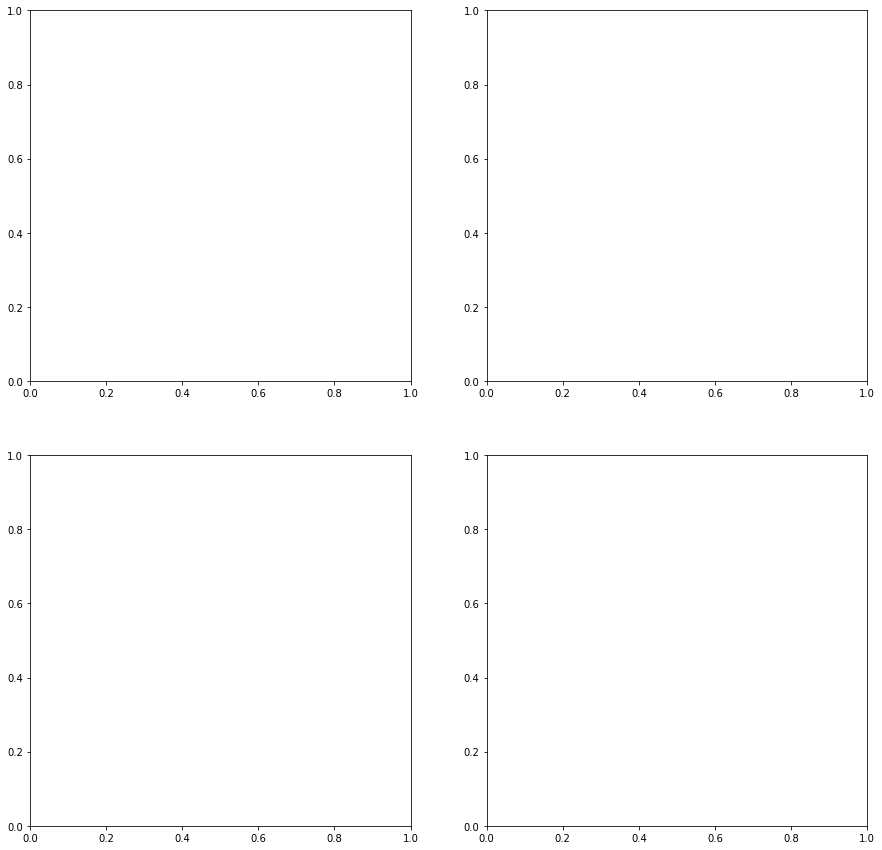

In [0]:
check_predictions(train_features, train_labels, val_features, val_labels)

Tuning parameter and finding best estimate using Random Grid Search

In [0]:

%%time
params = {
        'min_child_weight': [1, 5, 10],
        'alpha': [1,5,15,20],
        'learning_rate': [0.01,0.05,0.10,0.15],
        'subsample': [0.6, 0.8, 0.9],
        'colsample_bytree': [0.5, 0.6, 0.8, 1.0],
        'max_depth': [3,10,15,20],
        'n_estimators':  [60,500,1000,1500]
        }
search_grid = GridSearchCV(estimator= xg_reg, param_grid=params,cv=5,scoring=my_scorer,n_jobs=-1)
search_grid.fit(train_features,train_labels)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
val_pred_xg_grid = search_grid.best_estimator_.predict(val_features)
mse_xg_grid = (mean_absolute_error(val_labels,val_pred_xg_1))
print(mse_xg_grid)

101.53502430169094


In [0]:
train_pred_grid = search_grid.best_estimator_.predict(train_features)
print (mean_absolute_error(train_labels,train_pred_1))

78.98433804704118


In [0]:
search_grid.best_estimator_,search_grid.best_params_,search_grid.best_score_

(XGBRegressor(alpha=20, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              importance_type='gain', learning_rate=0.05, max_delta_step=0,
              max_depth=3, min_child_weight=10, missing=None, n_estimators=60,
              n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, verbosity=1),
 {'alpha': 20,
  'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 3,
  'min_child_weight': 10,
  'n_estimators': 60,
  'subsample': 1.0},
 82.43504505778121)

In [0]:

%%time
params_xg = {
        'min_child_weight': [ 5, 10],
        'alpha': [ 5,15,20,25],
        'learning_rate': [0.01,0.05,0.10,0.15],
        'subsample': [0.6, 1],
        'colsample_bytree': [0.2, 0.5],
        #'max_depth': [3, 8],
        'n_estimators':  [60,100,500,1000]
        }
search = RandomizedSearchCV(estimator= xg_reg, param_distributions=params_xg,cv=5,scoring=my_scorer,n_jobs=-1)
search.fit(train_features,train_labels)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[08:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4.44 s, sys: 216 ms, total: 4.65 s
Wall time: 9min 35s


This had 2 * 4 * 4 * 2 * 2 * 2 * 4 =  1024 combinations

In [0]:
val_pred_xg = search.best_estimator_.predict(val_features)
mse_xg = (mean_absolute_error(val_labels,val_pred_xg))
print(mse_xg)

359.7496072397004


In [0]:
train_pred = search.best_estimator_.predict(train_features)
print (mean_absolute_error(train_labels,train_pred))

563.9177327407612


In [0]:
search.best_estimator_,search.best_params_,search.best_score_

(XGBRegressor(alpha=15, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1.5,
              importance_type='gain', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=5, missing=None, n_estimators=60,
              n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1),
 {'colsample_bytree': 0.6,
  'gamma': 1.5,
  'learning_rate': 0.01,
  'max_depth': 3,
  'min_child_weight': 5,
  'n_estimators': 60,
  'subsample': 0.6},
 564.4151556659366)

In [0]:
%%time
xg_reg_final = xgb.XGBRegressor(alpha=20, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              importance_type='gain', learning_rate=0.05, max_delta_step=0,
              max_depth=3, min_child_weight=10, missing=None, n_estimators=60,
              n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, verbosity=1)
xg_reg_final.fit(train_features, train_labels)



/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[08:18:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 7.76 s, sys: 0 ns, total: 7.76 s
Wall time: 7.78 s


In [0]:
val_preds_f = xg_reg_final.predict(val_features)
print ("MSE_test: ", mean_absolute_error(val_labels,val_preds))


MSE_test:  286.5195904745303


**LIGHT GBM**

In [0]:
import lightgbm as ltb

In [0]:
%%time
train_data = ltb.Dataset(train_features, label=train_labels)
test_data = ltb.Dataset(val_features, label=val_labels)


CPU times: user 31 µs, sys: 0 ns, total: 31 µs
Wall time: 533 µs


In [0]:
 # fit a lightGBM model to the data
   %%time
   
   parameters = {
   
    'objective':'regression',
    'metric': 'mae',
     'boosting': 'gbdt',
     'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.02,
    
}

l_model = ltb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)
    
    
    

[1]	valid_0's l1: 152.295
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l1: 150.488
[3]	valid_0's l1: 148.432
[4]	valid_0's l1: 146.709
[5]	valid_0's l1: 146.111
[6]	valid_0's l1: 144.151
[7]	valid_0's l1: 142.271
[8]	valid_0's l1: 140.357
[9]	valid_0's l1: 139.875
[10]	valid_0's l1: 138.176
[11]	valid_0's l1: 137.793
[12]	valid_0's l1: 136.269
[13]	valid_0's l1: 135.937
[14]	valid_0's l1: 134.354
[15]	valid_0's l1: 133.859
[16]	valid_0's l1: 132.162
[17]	valid_0's l1: 131.722
[18]	valid_0's l1: 131.351
[19]	valid_0's l1: 129.804
[20]	valid_0's l1: 128.167
[21]	valid_0's l1: 127.776
[22]	valid_0's l1: 127.38
[23]	valid_0's l1: 125.837
[24]	valid_0's l1: 125.431
[25]	valid_0's l1: 123.848
[26]	valid_0's l1: 122.424
[27]	valid_0's l1: 122.241
[28]	valid_0's l1: 122.018
[29]	valid_0's l1: 121.656
[30]	valid_0's l1: 120.333
[31]	valid_0's l1: 118.908
[32]	valid_0's l1: 118.656
[33]	valid_0's l1: 117.239
[34]	valid_0's l1: 116.937
[35]	valid_0's l1: 116.716
[3

In [0]:
%%time
train_pred_lgb = l_model.predict(train_features)
print (mean_absolute_error(train_labels,train_pred_lgb))

20.209635559096306
CPU times: user 54 s, sys: 0 ns, total: 54 s
Wall time: 54.1 s


In [0]:
# make predictions
%%time
    val_pred_lgb = l_model.predict(val_features)
print (mean_absolute_error(val_labels,val_pred_lgb))

52.0828543478394
CPU times: user 6.12 s, sys: 0 ns, total: 6.12 s
Wall time: 6.14 s


In [0]:
%%time
lightgbm_params = {

        'bagging_fraction': (0.5, 0.8),
        'bagging_frequency': (5, 8,20,25),

        'feature_fraction': (0.5, 0.8),
        'max_depth': (3, 5,10,15),
        'min_data_in_leaf': (90, 120),
        'num_leaves': (1200, 1550),
        'learning_Rate' : (0.01,0.05,0.10,0.15)

}

# Initialize a RandomizedSearchCV object using 5-fold CV-
ltb_cv = RandomizedSearchCV(estimator=ltb.LGBMRegressor(), param_distributions=lightgbm_params, cv = 5, n_iter=100,verbose=1,scoring=my_scorer)

# Train on training data-
ltb_cv_fit = ltb_cv.fit(train_features, train_labels,verbose=1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [0]:
#data_dmatrix = xgb.DMatrix(data=train_features,label=train_labels)

This has 2 * 4 * 2 * 4 * 2 * 2 * 4 =  1024 combinations

In [0]:

%%time

print(ltb_cv_fit.best_Estimator_, ltb_cv_fit.best_params_, ltb_cv_fit.best_score_)
search.best_estimator_,search.best_params_,search.best_score_

In [0]:
%%time
train_ltb_cv_fit = ltb_cv_fit.predict(train_features)
print (mean_absolute_error(train_labels,train_ltb_cv_fit))

In [0]:
%%time
    val_ltb_cv_fit = ltb_cv_fit.predict(val_features)
print (mean_absolute_error(val_labels,val_ltb_cv_fit))

s.

In [0]:
%%time
solar_output = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1LKKPydF9Owcof9z2hSWjNQjQiy-tCLYa&export=download')
solar_output = solar_output[['Year','Month','Day','Daily global solar exposure (MJ/m*m)']]
df.insert(len(df.columns), 'day', df['Trading Interval'].dt.day)
df = df.merge(solar_output, left_on=['year','month','day'], right_on=['Year','Month','Day']).drop(['day', 'Year', 'Month', 'Day'], axis=1)

[rf,xg_reg, train_features, train_labels, val_features, val_labels] = train_forest(df.drop('Trading Interval', axis=1), 365*48)

That barely moved the dial on the validation set, if anything it probably made the results a bit worse.